# 道路標識検出リポジトリ
https://github.com/aarcosg/traffic-sign-detection<br>
GTSDB3([German Traffic Sign Detection Benchmark](https://benchmark.ini.rub.de/?section=gtsdb))

# 訓練済みモデル ダウンロード

In [1]:
# faster_rcnn_resnet50
!gdown https://drive.google.com/uc?id=1aEqlozB_CzhyJX_PO6SSiM-Yiv3fuO8V
!unzip faster_rcnn_resnet50.zip -d faster_rcnn_resnet50

Downloading...
From: https://drive.google.com/uc?id=1aEqlozB_CzhyJX_PO6SSiM-Yiv3fuO8V
To: /content/faster_rcnn_resnet50.zip
100% 105M/105M [00:01<00:00, 80.0MB/s]
Archive:  faster_rcnn_resnet50.zip
   creating: faster_rcnn_resnet50/inference_graph/
  inflating: faster_rcnn_resnet50/inference_graph/frozen_inference_graph.pb  
  inflating: faster_rcnn_resnet50/faster_rcnn_resnet50_coco_gtsdb3.config  
  inflating: faster_rcnn_resnet50/detections_output_result.pkl  


# ONNX変換

In [2]:
!pip install --user -U tf2onnx
!pip install onnx-simplifier

     |████████████████████████████████| 435 kB 18.1 MB/s 
     |████████████████████████████████| 12.7 MB 70.4 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 466 kB 15.3 MB/s 
     |████████████████████████████████| 4.9 MB 34.1 MB/s 
  Created wheel for onnx-simplifier: filename=onnx_simplifier-0.3.6-py3-none-any.whl size=12874 sha256=7404811ed1215a517d564b44480f7d1afa5bcdc99bb884fb60ec9296d2056d42
  Stored in directory: /root/.cache/pip/wheels/0c/47/80/8eb21098e22c19d60b1c14021ee67442b4ad2d7991fdad46ba
Successfully built onnx-simplifier


In [3]:
# faster_rcnn_resnet50
!python -m tf2onnx.convert \
    --graphdef faster_rcnn_resnet50/inference_graph/frozen_inference_graph.pb \
    --output faster_rcnn_resnet50.onnx \
    --fold_const \
    --opset 13 \
    --inputs image_tensor:0 \
    --outputs num_detections:0,detection_boxes:0,detection_scores:0,detection_classes:0

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
2022-01-13 13:46:06,961 - WARNING - From /root/.local/lib/python3.7/site-packages/tf2onnx/tf_loader.py:305: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-01-13 13:46:06,961 - WARNING - From /usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/convert_to_constants.py:929: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Inst

# サンプル画像読み込み

In [4]:
!pip install onnxruntime imread_from_url==0.1.2

  Created wheel for imread-from-url: filename=imread_from_url-0.1.2-py3-none-any.whl size=6564 sha256=0b52e0f57e9d8721d4df88e62142f7ec6a99f5e6bf2a04d4cd88a85fcd2e7eec
  Stored in directory: /root/.cache/pip/wheels/10/c4/e7/f5517a33d5b3bd6e32bba66ec56c2183037510439325a029d5
Successfully built imread-from-url


In [5]:
from imread_from_url import imread_from_url

image = imread_from_url(
    'https://raw.githubusercontent.com/aarcosg/traffic-sign-detection/master/test_images/image2.jpg'
)

# 推論テスト

In [6]:
import cv2
import numpy as np
import onnxruntime

# 前処理
input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = np.expand_dims(input_image, axis=0)
input_image = input_image.astype('uint8')

# モデル読み込み
onnx_session = onnxruntime.InferenceSession('faster_rcnn_resnet50.onnx')

# 入出力名取得
input_name = onnx_session.get_inputs()[0].name  # 'image'

output_name_boxes = onnx_session.get_outputs()[1].name  # 'boxes'
output_name_classes = onnx_session.get_outputs()[3].name  # 'classes'
output_name_scores = onnx_session.get_outputs()[2].name  # 'scores'
output_name_num = onnx_session.get_outputs()[0].name  # 'number of detections'

# 推論
result = onnx_session.run(
    [output_name_num, output_name_boxes, output_name_scores, output_name_classes],
    {input_name: input_image},
)

num_detections = result[0]
boxes = result[1]
scores = result[2]
classes = result[3]

In [7]:
import copy 

class_name = [
    'prohibitory',
    'mandatory',
    'danger',
]

image_width, image_height = image.shape[1], image.shape[0]
debug_image = copy.deepcopy(image)

for bbox, score, class_id in zip(boxes[0], scores[0], classes[0]):
    if score < 0.7:
        continue

    x1, y1 = int(bbox[1] * image_width), int(bbox[0] * image_height)
    x2, y2 = int(bbox[3] * image_width), int(bbox[2] * image_height)

    cv2.putText(
        debug_image, str(class_name[int(class_id) - 1]) + '{:.2f}'.format(score),
        (x1, y1 - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2,
        cv2.LINE_AA)
    cv2.rectangle(debug_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

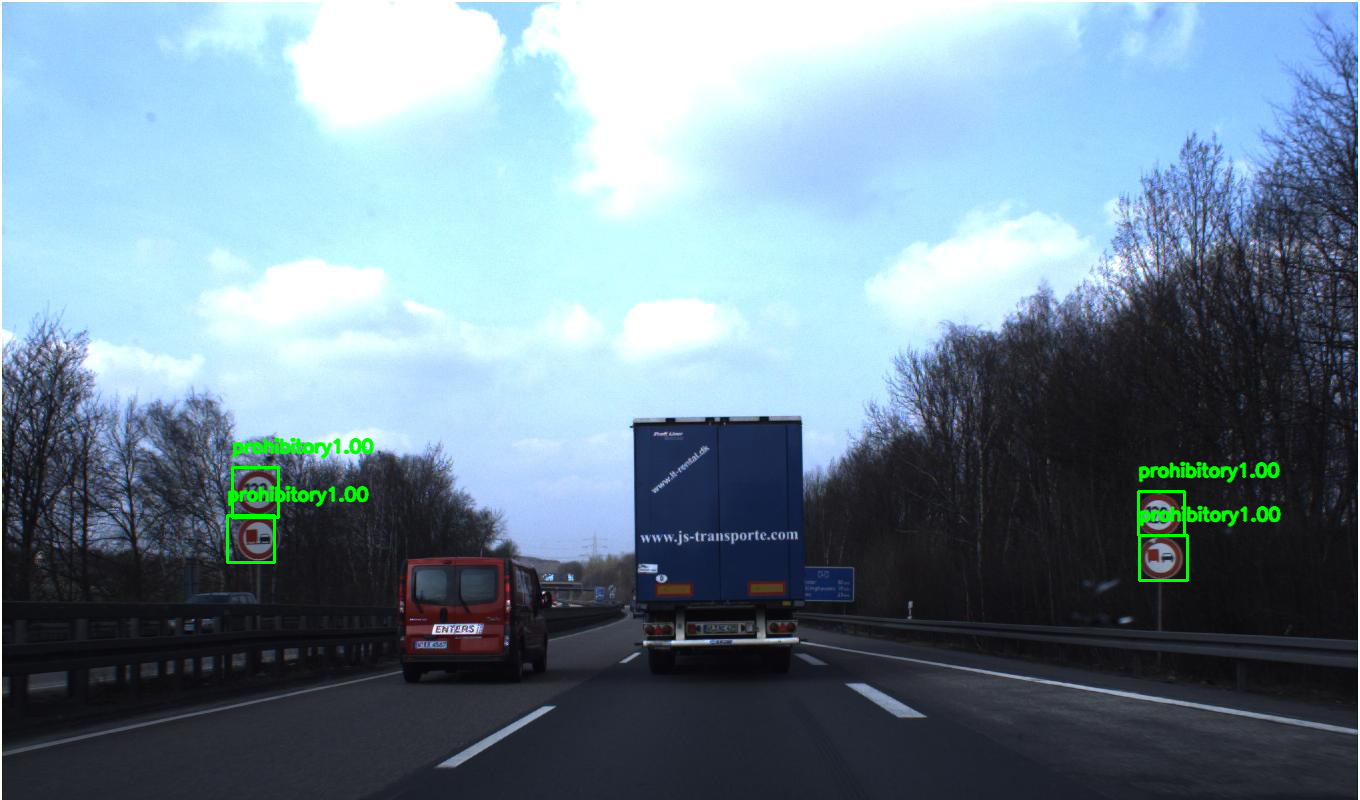

In [8]:
from google.colab.patches import cv2_imshow

cv2_imshow(debug_image)